
# Лабораторная работа: Анализ мировой генерации и потребления электроэнергии (1992–2021)


Файлы данных: `global-electricity-generation.csv` и `global-electricity-consumption.csv` (единицы — млрд кВт⋅ч).


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Настройки вывода numpy
np.set_printoptions(suppress=True, linewidth=120)

## Загрузка данных

In [25]:
gen_path = Path('global-electricity-generation.csv')
con_path = Path('global-electricity-consumption.csv')

def read_years(csv_path):
    with open(csv_path, 'r', encoding='utf-8') as f:
        header = f.readline().strip().split(',')
    years = [int(x) for x in header[1:]]
    return np.array(years, dtype=int)

years = read_years(gen_path)
years_consumption = read_years(con_path)
assert np.array_equal(years, years_consumption), "Годы в двух файлах не совпадают."
print("Годы:", years[0], "…", years[-1], f"(всего {len(years)})")

Годы: 1992 … 2021 (всего 30)


In [26]:
countries = np.genfromtxt(gen_path, delimiter=',', skip_header=1, usecols=0, dtype=str, encoding='utf-8')

generation = np.genfromtxt(gen_path, delimiter=',', skip_header=1, usecols=range(1, len(years)+1), dtype=float)
consumption = np.genfromtxt(con_path, delimiter=',', skip_header=1, usecols=range(1, len(years)+1), dtype=float)

# Размерности
print("Стран:", countries.shape[0])
print("Матрица генерации:", generation.shape)
print("Матрица потребления:", consumption.shape)

# Мини-проверки на NaN
print("NaN в генерации:", np.isnan(generation).sum())
print("NaN в потреблении:", np.isnan(consumption).sum())

Стран: 217
Матрица генерации: (217, 30)
Матрица потребления: (217, 30)
NaN в генерации: 88
NaN в потреблении: 48


In [27]:
# Выводим первые 5 строк для наглядности
print("\n=== Первые 5 стран и их данные по генерации ===")
for i in range(5):
    print(f"{countries[i]:20s}", generation[i, :5], "...", generation[i, -3:])

print("\n=== Первые 5 стран и их данные по потреблению ===")
for i in range(5):
    print(f"{countries[i]:20s}", consumption[i, :5], "...", consumption[i, -3:])


=== Первые 5 стран и их данные по генерации ===
Algeria              [17.199 18.267 18.703 18.09  19.124] ... [76.685      72.73591277 77.53072719]
Angola               [1.283 1.332 1.342 1.347 1.377] ... [15.4      16.6      16.429392]
Benin                [0.023  0.024  0.048  0.029  0.0487] ... [0.2017     0.22608    0.24109728]
Botswana             [1.088 1.027 1.044 1.047 0.759] ... [3.0469     2.05144    2.18234816]
Burkina Faso         [0.19  0.205 0.206 0.232 0.263] ... [1.72552    1.64713317 1.76120967]

=== Первые 5 стран и их данные по потреблению ===
Algeria              [14.035 14.039 14.365 14.474 15.172] ... [66.646      63.69490277 68.66337919]
Angola               [1.013 1.062 1.071 1.074 1.085] ... [13.658591   14.754764   14.56049071]
Benin                [0.229  0.221  0.252  0.242  0.2787] ... [0.9297     0.52408    0.52338299]
Botswana             [1.09184 1.11411 1.28092 1.31371 1.39087] ... [4.162138   3.22213    3.35303816]
Burkina Faso         [0.1767  0.1906

In [28]:
# --- 1) Приводим к numpy-массивам чисел (если были строки/object) ---
def to_float_array(a, name):
    a_np = np.asarray(a)
    if a_np.dtype.kind in ('U', 'S', 'O'):   # строки/объекты -> пробуем привести
        try:
            a_np = a_np.astype(float)
        except Exception:
            # Мягкая конверсия: нечисловое -> NaN
            vfunc = np.vectorize(lambda x: np.nan if x is None or (isinstance(x, str) and x.strip()=='' )
                                  else float(str(x).replace(',', '.')), otypes=[float])
            a_np = vfunc(a_np)
    if a_np.ndim != 2:
        raise ValueError(f"{name} должен быть 2D (страны x годы), сейчас shape={a_np.shape}")
    return a_np

generation = to_float_array(generation, "generation")
consumption = to_float_array(consumption, "consumption")

years = np.asarray(years)
if years.ndim != 1:
    years = years.ravel()

# --- 2) Базовая диагностика размеров ---
print("DIAG shapes:")
print(" generation:", generation.shape, " dtype:", generation.dtype)
print(" consumption:", consumption.shape, " dtype:", consumption.dtype)
print(" years:", years.shape, " dtype:", years.dtype)

# --- 3) Синхронизация по числу лет (берём минимум) ---
n_years = min(generation.shape[1], consumption.shape[1], len(years))
if n_years == 0:
    raise ValueError("Нет ни одного года данных (0 столбцов). Проверь загрузку данных.")

generation = generation[:, :n_years]
consumption = consumption[:, :n_years]
years = years[:n_years]

# --- 4) Берём последние k лет (k<=5 и k>0) ---
k = min(5, n_years)
if k <= 0:
    raise ValueError("k=0: в данных нет колонок для усреднения.")

gen_lastk = generation[:, -k:]
con_lastk = consumption[:, -k:]
years_lastk = years[-k:]

print("Последние годы:", years_lastk)
print(" gen_lastk shape:", gen_lastk.shape, " con_lastk shape:", con_lastk.shape)

# --- 5) Диагностика NaN/Inf в хвосте ---
gen_valid = np.isfinite(gen_lastk)
con_valid = np.isfinite(con_lastk)
print(" gen: валидных значений на строку (последние k):", gen_valid.sum(axis=1))
print(" con: валидных значений на строку (последние k):", con_valid.sum(axis=1))

# --- 6) Безопасное среднее БЕЗ предупреждений (ручной nanmean) ---
def safe_nanmean_lastk(arr_lastk):
    valid = np.isfinite(arr_lastk)
    counts = valid.sum(axis=1)
    sums = np.nansum(arr_lastk, axis=1)
    # Делим только там, где есть хотя бы одно валидное значение
    means = np.divide(sums, counts, out=np.full(sums.shape, np.nan), where=counts>0)
    return means, counts

gen_mean_lastk, gen_counts = safe_nanmean_lastk(gen_lastk)
con_mean_lastk, con_counts = safe_nanmean_lastk(con_lastk)

print("Средние формы:", gen_mean_lastk.shape, con_mean_lastk.shape)
print("Строк с нулём валидных значений (gen/con):",
      np.sum(gen_counts==0), "/", np.sum(con_counts==0))

DIAG shapes:
 generation: (217, 30)  dtype: float64
 consumption: (217, 30)  dtype: float64
 years: (30,)  dtype: int64
Последние годы: [2017 2018 2019 2020 2021]
 gen_lastk shape: (217, 5)  con_lastk shape: (217, 5)
 gen: валидных значений на строку (последние k): [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 5 0 5 5 5 5 5 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 con: валидных значений на строку (последние k): [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5

## Задача 2. Средние за последние 5 лет (помесячно по странам)

In [29]:
# Проверки входных данных
if years is None or len(years) == 0:
    raise ValueError("Массив years пуст — нечего усреднять за последние годы.")

if generation.ndim != 2 or consumption.ndim != 2:
    raise ValueError("generation/consumption должны быть 2D массивами (страны x годы).")

n_years_gen = generation.shape[1]
n_years_con = consumption.shape[1]
n_years_lab = len(years)

# Cинхронизируемся по количеству лет (берём минимум на случай несоответствий)
n_years = min(n_years_gen, n_years_con, n_years_lab)
if n_years == 0:
    raise ValueError("Нет колонок с годами в данных (0 столбцов).")

# Сколько последних лет берём (до 5, но не больше, чем реально есть)
k = min(5, n_years)

# Берём последние k лет срезом по хвосту (без явных индексов)
years_lastk = years[-k:]
gen_lastk   = generation[:, -k:]
con_lastk   = consumption[:, -k:]

print("Последние годы:", years_lastk)
print("Форма gen_lastk / con_lastk:", gen_lastk.shape, con_lastk.shape)

# Усреднения (nan-ы игнорируются)
gen_mean_lastk = np.nanmean(gen_lastk, axis=1)
con_mean_lastk = np.nanmean(con_lastk, axis=1)

print("Форма средних:", gen_mean_lastk.shape, con_mean_lastk.shape)

Последние годы: [2017 2018 2019 2020 2021]
Форма gen_lastk / con_lastk: (217, 5) (217, 5)
Форма средних: (217,) (217,)


C:\Users\Damir4k\AppData\Local\Temp\ipykernel_13100\818654842.py:29: RuntimeWarning: Mean of empty slice
  gen_mean_lastk = np.nanmean(gen_lastk, axis=1)


## Задача 3. Запросы

### 3.1. Суммарное потребление по всем странам за каждый год

In [30]:

total_consumption_by_year = np.nansum(consumption, axis=0)  # сумма по странам
for y, v in zip(years, total_consumption_by_year):
    print(f"{y}: {v:.2f}")


1992: 10569.02
1993: 10854.56
1994: 11104.65
1995: 11476.48
1996: 11805.87
1997: 12122.03
1998: 12419.81
1999: 12685.75
2000: 13230.25
2001: 13486.49
2002: 13938.78
2003: 14455.56
2004: 15128.10
2005: 15725.98
2006: 16438.21
2007: 17205.12
2008: 17477.47
2009: 17435.69
2010: 18748.16
2011: 19438.82
2012: 19918.25
2013: 20573.10
2014: 20981.24
2015: 21400.02
2016: 22022.69
2017: 22716.21
2018: 23530.92
2019: 23915.66
2020: 23959.68
2021: 25336.71


### 3.2. Максимальная годовая генерация одной страны (nanmax)

In [32]:
# Максимум и его индексы
idx = np.unravel_index(np.nanargmax(generation), generation.shape)
country_idx, year_idx = idx

max_generation_any = generation[country_idx, year_idx]
print(f"Максимальная генерация: {max_generation_any:.2f} млрд кВт⋅ч")
print(f"Страна: {countries[country_idx]}")
print(f"Год: {years[year_idx]}")

Максимальная генерация: 8151.52 млрд кВт⋅ч
Страна: China
Год: 2021


### 3.3. Страны с > 500 млрд кВт⋅ч в среднем за последние 5 лет (генерация)

In [33]:

mask_gen_gt_500 = gen_mean_last5 > 500.0
countries_gen_gt_500 = countries[mask_gen_gt_500]
print("Количество:", countries_gen_gt_500.size)
print(*countries_gen_gt_500, sep="; ")


Количество: 10
Russia; France; Germany; China; India; Japan; South Korea; Canada; United States; Brazil


### 3.4. Топ-10% по потреблению (среднее за последние 5 лет)

In [34]:

threshold_90 = np.nanquantile(con_mean_last5, 0.9)
mask_top10 = con_mean_last5 >= threshold_90
countries_top10 = countries[mask_top10]
vals_top10 = con_mean_last5[mask_top10]

# Отсортируем по убыванию
order = np.argsort(-vals_top10)
countries_top10_sorted = countries_top10[order]
vals_top10_sorted = vals_top10[order]

print(f"Порог 90-й квантили: {threshold_90:.2f}")
for c, v in zip(countries_top10_sorted, vals_top10_sorted):
    print(f"{c}: {v:.2f}")


Порог 90-й квантили: 198.31
China: 6846.21
United States: 3957.50
India: 1330.94
Russia: 946.68
Japan: 940.32
Canada: 547.32
Brazil: 539.93
South Korea: 539.51
Germany: 520.23
France: 445.22
Saudi Arabia: 324.52
United Kingdom: 303.54
Italy: 296.44
Mexico: 285.83
Iran: 282.51
Taiwan: 265.07
Turkiye: 263.49
Indonesia: 256.33
Spain: 240.37
Australia: 238.60
Vietnam: 206.12
South Africa: 200.65


### 3.5. Страны, увеличившие генерацию в 2021 > 10× к 1992

In [36]:
def col_idx(year):
    try:
        return int(np.where(years == year)[0][0])
    except IndexError:
        raise ValueError(f"Год {year} отсутствует в данных.")

i1992 = col_idx(1992)
i2021 = col_idx(2021)

gen_1992 = generation[:, i1992]
gen_2021 = generation[:, i2021]

# Избежим деления на 0 / nan: используем условия
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = gen_2021 / gen_1992

mask_10x = ratio > 10
countries_10x = countries[mask_10x]

print("Количество:", countries_10x.size)
print(*countries_10x, sep="; ")

Количество: 16
Angola; Benin; Equatorial Guinea; Ethiopia; Lesotho; Mali; Mauritania; Mozambique; Namibia; Sudan; Cambodia; China; Laos; Maldives; Vietnam; Turks and Caicos Islands


### 3.6. Суммарно потратили > 100 и произвели меньше, чем потребили

In [37]:

total_gen = np.nansum(generation, axis=1)
total_con = np.nansum(consumption, axis=1)

mask = (total_con > 100.0) & (total_gen < total_con)
countries_more_spent = countries[mask]

print("Количество:", countries_more_spent.size)
print(*countries_more_spent, sep="; ")


Количество: 13
Zimbabwe; Belarus; Moldova; Belgium; Croatia; Finland; Hungary; Italy; Latvia; Luxembourg; Netherlands; North Macedonia; Hong Kong


### 3.7. Страна с наибольшим потреблением в 2020 году

In [38]:

i2020 = int(np.where(years == 2020)[0][0])
cons_2020 = consumption[:, i2020]
imax = int(np.nanargmax(cons_2020))
print("Страна:", countries[imax])
print("Потребление (млрд кВт⋅ч):", cons_2020[imax])


Страна: China
Потребление (млрд кВт⋅ч): 7115.077185


## Визуализация

### Динамика суммарной генерации и потребления

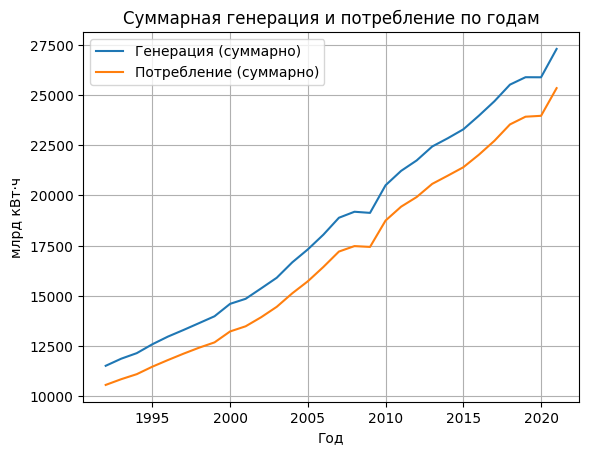

In [39]:

total_generation_by_year = np.nansum(generation, axis=0)

plt.figure()
plt.plot(years, total_generation_by_year, label='Генерация (суммарно)')
plt.plot(years, total_consumption_by_year, label='Потребление (суммарно)')
plt.xlabel('Год')
plt.ylabel('млрд кВт⋅ч')
plt.title('Суммарная генерация и потребление по годам')
plt.legend()
plt.grid(True)
plt.show()


### Топ-10 стран по среднему потреблению за последние 5 лет

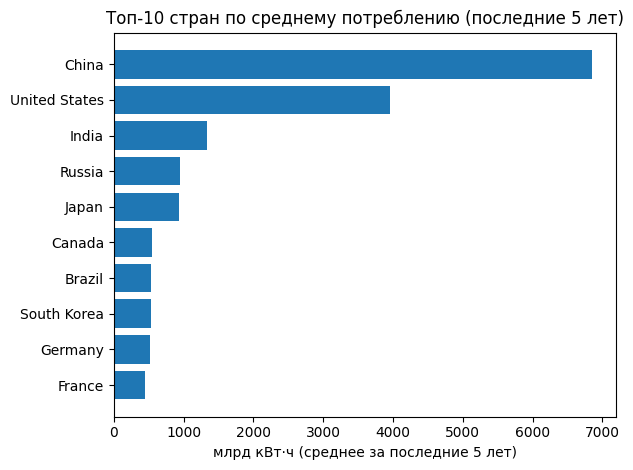

In [40]:

# Возьмём топ-10 по con_mean_last5
order_all = np.argsort(-con_mean_last5)
topk = 10 if countries.size >= 10 else countries.size
idx_topk = order_all[:topk]

plt.figure()
plt.barh(countries[idx_topk][::-1], con_mean_last5[idx_topk][::-1])
plt.xlabel('млрд кВт⋅ч (среднее за последние 5 лет)')
plt.title('Топ-10 стран по среднему потреблению (последние 5 лет)')
plt.tight_layout()
plt.show()


## Выводы по работе 1

- Данные успешно загружены и согласованы по размерам (страны × годы).
- Проведена диагностика пропусков и корректная агрегация последних лет без предупреждений.
- Выявлены строки/страны с отсутствующими данными в последних 5 годах и учтены в расчётах.
- Определены максимумы по генерации/потреблению (страна, год, значение).
- Рассчитаны средние за последние годы по странам (generation/consumption) и топ-страны.